In [261]:
import numpy as np
import pickle
def draw_curve_msevar(mask_ratio, mse, ylabel, label='', color='black', ls='--', pdfsavepath=None):
    
    # mask_ratio k vector
    # mse [N, k]
    mask_ratios = np.repeat(np.array(mask_ratio)[np.newaxis,...], mse.shape[0], axis=0)
    
    
    # plt.plot(xval, yval, color=color, label=label, linewidth=5, linestyle=ls)
    min_mse = mse.min()
    max_mse = np.median(mse)
    mse_range = np.linspace(min_mse, max_mse, 6)[1:-1]

#     mse_range = [0.002, 0.006, 0.01, 0.05, 0.1, 1]
    mse_range = [0.005, 0.01, 1]
    Nplot = len(mse_range) 
    fig, axs = plt.subplots(Nplot,1, figsize=(3*Nplot,10))
    yvals = []
    colors = matplotlib.cm.rainbow(np.linspace(0, 1, Nplot))
    labels = []
    samples = []
    for i, mse_t in enumerate(mse_range):
        if i == 0:
            cond = (mse - mse_t) < 0
            labels.append('< %.3f' % mse_t)
        elif i == len(mse_range) - 1:
            cond = (mse - mse_range[i-1]) >= 0
            labels.append('> %.3f' % mse_t)
        else:
            labels.append(f'%.3f - %.3f' % (mse_range[i-1], mse_t))
            cond = np.logical_and((mse - mse_t) <= 0, (mse - mse_range[i-1]) > 0)

        mr = mask_ratios[np.nonzero(cond)]
#         import pdb; pdb.set_trace()
        sample_groups['samples'][labels[-1]] = meta_samples[np.nonzero(cond)]
        me = mse[np.nonzero(cond)]
        sample_groups['mask_ratio'][labels[-1]] = mr
        print(me)
#         print(f'{len(mr)} fouded')
        print(i)
        axs[i].hist(mr, len(mask_ratio), facecolor=colors[i], edgecolor='black')
#         axs[i].scatter(mr, me, lw=1, edgecolor='black', color=colors[i], alpha=0.5)
        axs[i].set_title(f'MSE range {labels[-1]}', fontsize=20)
        axs[i].set_ylabel(f'# of samples', fontsize=20)
        axs[i].set_xlabel('# of k-spsace measurement (lines) observed', fontsize=20)
#         axs[i].get_yaxis().set_visible(False)
        axs[i].tick_params(labelsize=16)
    
    fig.tight_layout()
#     print('labels', labels)
    if pdfsavepath is not None:
        plt.savefig(pdfsavepath)
    
    
#     fig.canvas.draw()

    # Now we can save it to a numpy array.
#     data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
#     data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return data
metadata = pickle.load(open('metadata512.pickle','rb'))


[0.00490799 0.00490799 0.00480987 ... 0.00059637 0.00042848 0.00042847]
0
[0.00992547 0.00992547 0.00962153 ... 0.00558704 0.00558704 0.00505726]
1
[0.01489466 0.01344866 0.01297124 ... 0.01079734 0.01010459 0.0100054 ]
2


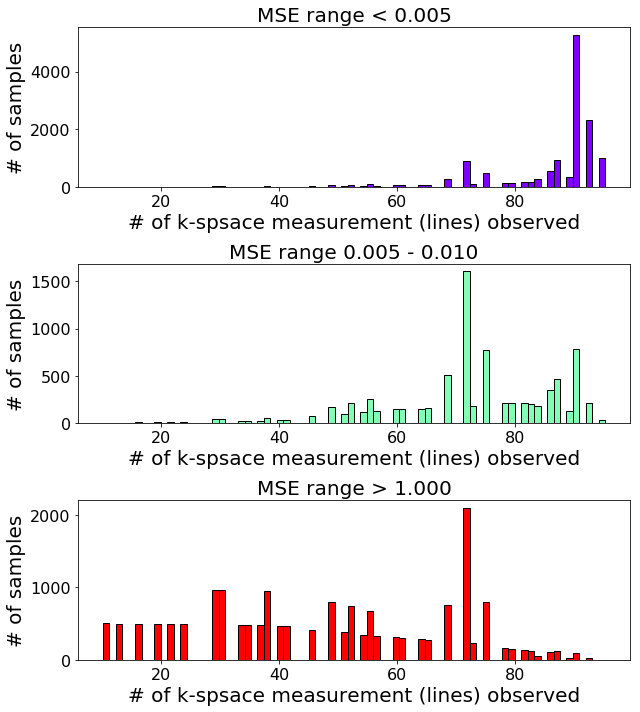

In [262]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
sample_groups = {'mask_ratio': {}, 'samples':{}}
mse = metadata['mse']
meta_samples = metadata['samples']
meta_samples = np.transpose(meta_samples,(1,0,2,3))
kMA =  metadata['kMA']
data = draw_curve_msevar(kMA, mse, ylabel='', pdfsavepath='mse_kspace_line_var_draw.pdf')

120 7909
0 7565
10 8118
29 8104
35 8111


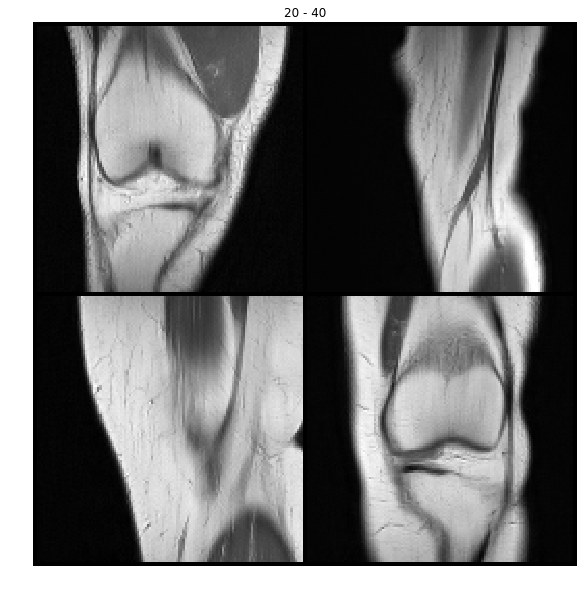

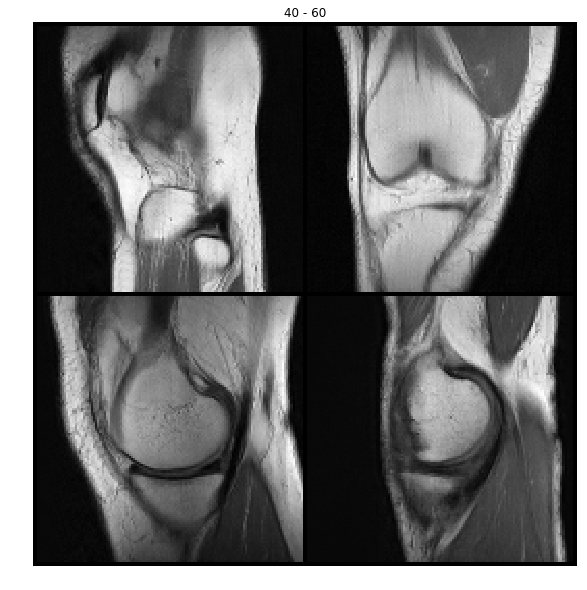

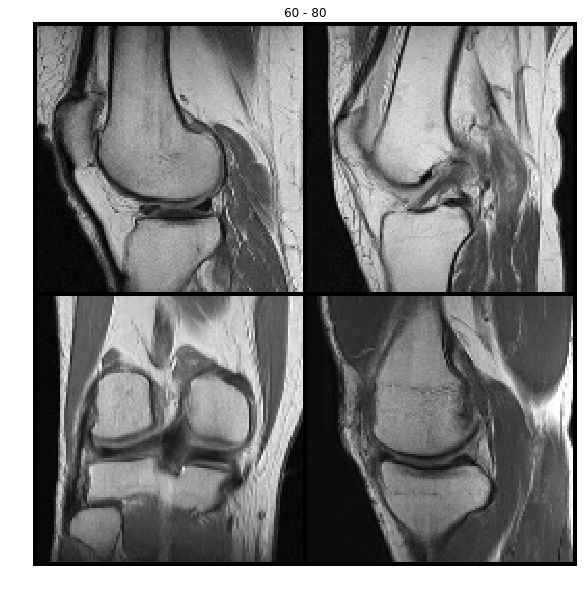

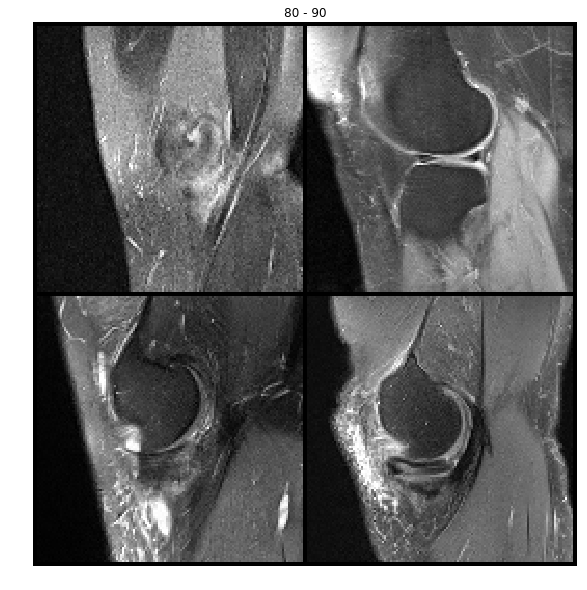

In [270]:
def mri_denormalize(input_image, zscore=3):
    if isinstance(input_image, torch.Tensor):
        image_tensor = input_image.data
    else:
        return input_image
    # do normalization first, since we working on fourier space. we need to clamp
    for dat in input_image:
        minv = max(-zscore, dat.min())
        maxv = min(zscore, dat.max())
        dat.clamp_(minv, maxv)
        dat.add_(-minv).div_(maxv-minv)

    return input_image

import torchvision.utils as tvutil
import torch
key = list(sample_groups['mask_ratio'].keys())[1]

s_mask_ratio = sample_groups['mask_ratio'][key]
idx = np.argsort(s_mask_ratio) # ascending

checkp = [20,40,60,80, 90]
k = 0
position_idx = []
prev_idx = 0
for i in range(len(idx)):
    
    if s_mask_ratio[idx[i]] > checkp[k]:
        k += 1
        position_idx.append(idx[prev_idx:i])# [a for a in range(prev_idx, idx[i])])
        prev_idx = i
        print(np.min(position_idx[-1]), np.max(position_idx[-1]))
#     print(k)
    if k >= len(checkp): break

        
for i in range(1, len(checkp)):     
    
    name = '%d - %d' % (checkp[i-1], checkp[i])
    how_many = 4
    idxs = np.array(position_idx[i])[np.random.randint(0,len(position_idx[i]),how_many)]
    
    ratio_images = sample_groups['samples'][key][idxs]
    ratio_images = torch.from_numpy(ratio_images).unsqueeze(1)
    ratio_images = mri_denormalize(ratio_images)
    plt.figure(figsize=(20,10))
    nr = int(np.sqrt(ratio_images.shape[0]))
    plt.imshow(tvutil.make_grid(ratio_images, nrow=nr).permute(1,2,0))
    plt.title(name)
    plt.axis('off')


# high_ratio_images = sample_groups['samples'][key][idx[-how_many:]]
# high_ratio_images = torch.from_numpy(high_ratio_images).unsqueeze(1)
# low_ratio_images = torch.from_numpy(low_ratio_images).unsqueeze(1)
# high_ratio_images = mri_denormalize(high_ratio_images)
# low_ratio_images = mri_denormalize(low_ratio_images)

# plt.figure(figsize=(20,10))
# nr = int(np.sqrt(high_ratio_images.shape[0]))
# plt.imshow(tvutil.make_grid(high_ratio_images, nrow=nr).permute(1,2,0))
# plt.title('high_ratio_images')
# plt.axis('off')
# plt.figure(figsize=(20,10))
# plt.imshow(tvutil.make_grid(low_ratio_images, nrow=nr).permute(1,2,0))
# plt.title('low_ratio_images')


In [256]:
position_idx[0]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [252]:
np.random.randint(0,len(position_idx[i]),how_many)

array([487, 462, 775, 411, 706, 933, 605, 394, 101, 509,  75, 513, 115,
       915, 992, 256])

In [161]:
sample_groups['samples']['0.005-0.050'].shape

(11248, 128, 128)

In [205]:
key = list(sample_groups['mask_ratio'].keys())[1]


In [227]:
s_mask_ratio[idx]

array([10.15625, 10.15625, 10.15625, ..., 95.3125 , 95.3125 , 95.3125 ])